In [8]:
!pip install -q --upgrade pip
!pip install -q diffusers transformers accelerate safetensors huggingface_hub xformers pillow


In [9]:
# from huggingface_hub import notebook_login
# print("Run notebook_login() and paste your HF token if you need access to gated models.")
# # notebook_login()   # <--- uncomment to run interactive login


In [10]:
# Robust model loader (paste & run this cell)
# - Runs notebook_login() if not authenticated
# - Loads MODEL_ID without using `revision="fp16"`
# - Uses fp16 when CUDA is available
# - Gives clear errors & suggestions if loading fails

from huggingface_hub import notebook_login, whoami
import os, torch, traceback, sys
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

MODEL_ID = "runwayml/stable-diffusion-v1-5"  # set the model id you accepted on HF
print("MODEL_ID =", MODEL_ID)

# 1) Ensure HF login (interactive) so gated models can be downloaded
try:
    me = whoami()
    print("Hugging Face already logged in as:", me.get('name') if isinstance(me, dict) else me)
except Exception:
    print("Not authenticated with Hugging Face. Running interactive login (paste your token when prompted).")
    notebook_login()

# 2) Device & dtype
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32
print("Device:", device, " dtype:", dtype)

# 3) Try loading the model (no revision param)
try:
    print("Loading model (this may take a minute). If you hit a 403/404, ensure you accepted the model license on the Hugging Face model page.")
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=dtype,
        # use_auth_token is deprecated in some versions; notebook_login provides auth
    )
    # optional: better scheduler
    try:
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    except Exception:
        pass

    # Move to device and enable optimizations for CUDA
    pipe = pipe.to(device)
    if device == "cuda":
        try:
            pipe.enable_xformers_memory_efficient_attention()
            print("xFormers enabled (if supported).")
        except Exception as e:
            print("xFormers not enabled:", e)
    print("Model loaded successfully on", device)

except Exception as e:
    print("\nFailed to load model. Details follow:\n")
    traceback.print_exc()
    # Helpful troubleshooting output:
    print("\n--- Troubleshooting actions ---")
    print("1) Make sure you accepted the model license on Hugging Face model page (open the MODEL_ID URL and click 'I accept').")
    print("2) Ensure your HF token has 'read' scope and you pasted it into the interactive login.")
    print("3) Double-check MODEL_ID is correct and spelled exactly. Common examples:")
    print("   - runwayml/stable-diffusion-v1-5")
    print("   - stabilityai/stable-diffusion-2-1")
    print("4) If you can't authenticate, consider uploading a local checkpoint into Colab or using a public model.")
    print("5) If error mentions 'Found no NVIDIA driver', enable GPU in Runtime -> Change runtime type -> GPU and restart the runtime.")
    sys.exit(1)


MODEL_ID = runwayml/stable-diffusion-v1-5
Not authenticated with Hugging Face. Running interactive login (paste your token when prompted).


Device: cuda  dtype: torch.float16
Loading model (this may take a minute). If you hit a 403/404, ensure you accepted the model license on the Hugging Face model page.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

xFormers enabled (if supported).
Model loaded successfully on cuda


In [11]:
from PIL import Image, ImageDraw, ImageFont
import json, datetime
import os

OUTPUT_DIR = "outputs" # Define OUTPUT_DIR
os.makedirs(OUTPUT_DIR, exist_ok=True) # Create the directory if it doesn't exist

BANNED = {"rape","child","illegal","nsfw","porn","gore","torture"}

def is_allowed(prompt):
    found = [w for w in BANNED if w in prompt.lower()]
    return (len(found)==0, found)

def apply_watermark(img, text="AI Generated"):
    try:
        draw = ImageDraw.Draw(img)
        w,h = img.size
        fontsize = max(12, w//40)
        try:
            font = ImageFont.truetype("arial.ttf", fontsize)
        except:
            font = ImageFont.load_default()
        tw,th = draw.textsize(text, font=font)
        x,y = w - tw - 10, h - th - 10
        draw.rectangle([x-6,y-6,x+tw+6,y+th+6], fill=(0,0,0,120))
        draw.text((x,y), text, fill=(255,255,255), font=font)
    except:
        pass
    return img

def save_with_meta(img, prompt, params, out_dir=OUTPUT_DIR, fname=None, watermark=True):
    if fname is None:
        fname = f"img_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.png"
    if watermark:
        img = apply_watermark(img)
    path = os.path.join(out_dir, fname)
    img.save(path)
    meta = {"filename": fname, "prompt": prompt, "params": params, "timestamp": str(datetime.datetime.utcnow())}
    meta_path = os.path.join(out_dir, "metadata.json")
    data = []
    if os.path.exists(meta_path):
        try:
            with open(meta_path, "r", encoding="utf-8") as f:
                data = json.load(f)
        except:
            data = []
    data.append(meta)
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)
    return path, meta_path


Generating...


  0%|          | 0/25 [00:00<?, ?it/s]

Saved: outputs/gen_1_a_family_in_park,_4k.png


/tmp/ipython-input-2718451657.py:38: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  meta = {"filename": fname, "prompt": prompt, "params": params, "timestamp": str(datetime.datetime.utcnow())}


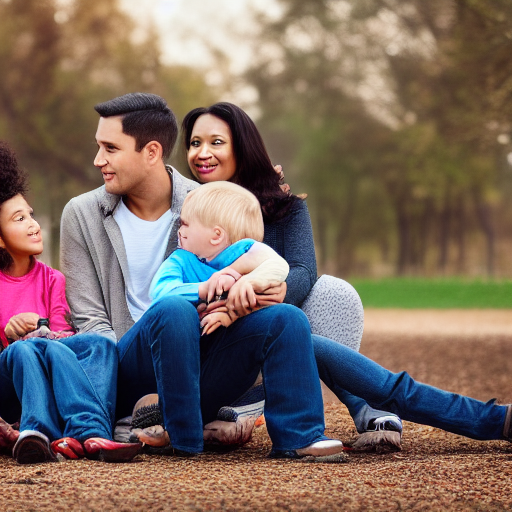

Metadata: outputs/metadata.json


In [15]:
# --- Edit these variables only ---
prompt = "a family in park, 4k"
negative_prompt = "lowres, extra fingers"
num_images = 1
height = 512
width = 512
steps = 25
guidance = 7.5
apply_wm = True   # watermark on saved image (True/False)
format_choice = "PNG"  # "PNG" or "JPEG"
# -------------------------------

ok, found = is_allowed(prompt)
if not ok:
    print("Prompt blocked. Forbidden tokens:", found)
else:
    print("Generating...")
    # Note: diffusers uses num_images_per_prompt OR num_images depending on version.
    # We call with num_images (works in typical setups).
    out = pipe(
        prompt=prompt,
        negative_prompt=(negative_prompt if negative_prompt.strip() else None),
        num_inference_steps=steps,
        guidance_scale=guidance,
        height=height,
        width=width,
        num_images=num_images
    )
    imgs = out.images
    for i, img in enumerate(imgs, start=1):
        safe_name = prompt[:40].strip().replace(" ", "_").replace("/", "_")
        fname = f"gen_{i}_{safe_name}.{format_choice.lower()}"
        path, meta_path = save_with_meta(
            img,
            prompt,
            {"height": height, "width": width, "steps": steps, "guidance": guidance, "format": format_choice},
            fname=fname,
            watermark=apply_wm
        )
        print("Saved:", path)
        display(img)
    print("Metadata:", meta_path)
